## Processing Sensor Data from Catalina Jemez CZO BGZOB Pit 1
- Marc Berghouse 9/19/2020: original format
- Zach Perzan 9/23/2020: improved format and working PRISM concat

This array includes:
- apogee_SO110
- Vaisala_GMM220
- DecagonMPS6
- Decagon5TE
- Vertical redox prodes from Paleo Terra

Issues:
- 2 sensors at 60cm. Not sure if the mask applied to O2 data should be lower.
- I'm not sure which water potential values are unrealistic


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

In [2]:
infiles = ["../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_co2o2_2014.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_co2o2_2015.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_co2o2_2016.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_co2o2_2017.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_soilMTP_2014.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_soilMTP_2015.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_soilMTP_2016.csv", 
           "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BGZOB1_soilMTP_2017.csv"]  
        
infiles_redox = ["../../raw_data/Catalina-Jemez/BGZOB_Pit1/BigelowRedox_2015.csv", 
            "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BigelowRedox_2016.csv", 
             "../../raw_data/Catalina-Jemez/BGZOB_Pit1/BigelowRedox_2017.csv"]

# Lists of all dataframes
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1]) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
for infile in tqdm(infiles_redox):
    df2 = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0, skiprows=[1], usecols = ['DateTime','Pit1_ORP_5','Pit1_ORP_10','Pit1_ORP_30','Pit1_ORP_60']) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df2)


prism_path = "../../raw_data/Catalina-Jemez/Catalina-Jemez_BGZOB_PRISM.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:
columns=['ApogeeTemp_10cm.deg.C', 'ApogeeTemp_30cm.deg.C', 'ApogeeTemp_60cm.deg.C', 
         'ApogeeTemp_60(2)cm.deg.C', 'O2_10cm.percent.0-100','O2_30cm.percent.0-100',
         'O2_60cm.percent.0-100', 'O2_60(2)cm.percent.0-100', 'CO2_10cm.ppm', 'CO2_30cm.ppm', 
         'CO2_60cm.ppm', 'CO2_60(2)cm.ppm', 'WaterPotential_10cm.kPa','WaterPotential_30cm.kPa',
         'DecagonMPS6Temp_10cm.deg.C','DecagonMPS6Temp_30cm.deg.C', 'SoilMoisture_10cm.m3m3', 
         'SoilMoisture_30cm.m3m3', 'SoilMoisture_60cm.m3m3', 'SoilMoisture_60(2)cm.m3m3', 
         'BulkEC_10cm.dS/m', 'BulkEC_30cm.dS/m', 'BulkEC_60cm.dS/m', 'BulkEC_60(2)cm.dS/m', 
         'Decagon5TETemp_10cm.deg.C','Decagon5TETemp_30cm.deg.C', 'Decagon5TETemp_60cm.deg.C', 
         'Decagon5TETemp_60(2)cm.deg.C','ReductionPotential_5cm.mV', 'ReductionPotential_10cm.mV',
         'ReductionPotential_30cm.mV', 'ReductionPotential_60cm.mV' ]

# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
ppt = ppt.drop(pd.date_range('2013-03-08', '2014-11-21'), errors='ignore')
#ppt = ppt.drop(pd.date_range('2018-10-02', '2019-06-24'), errors='ignore')
hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

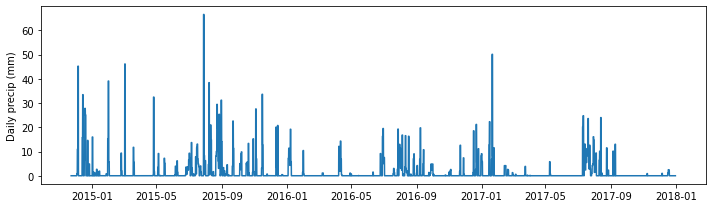

In [5]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

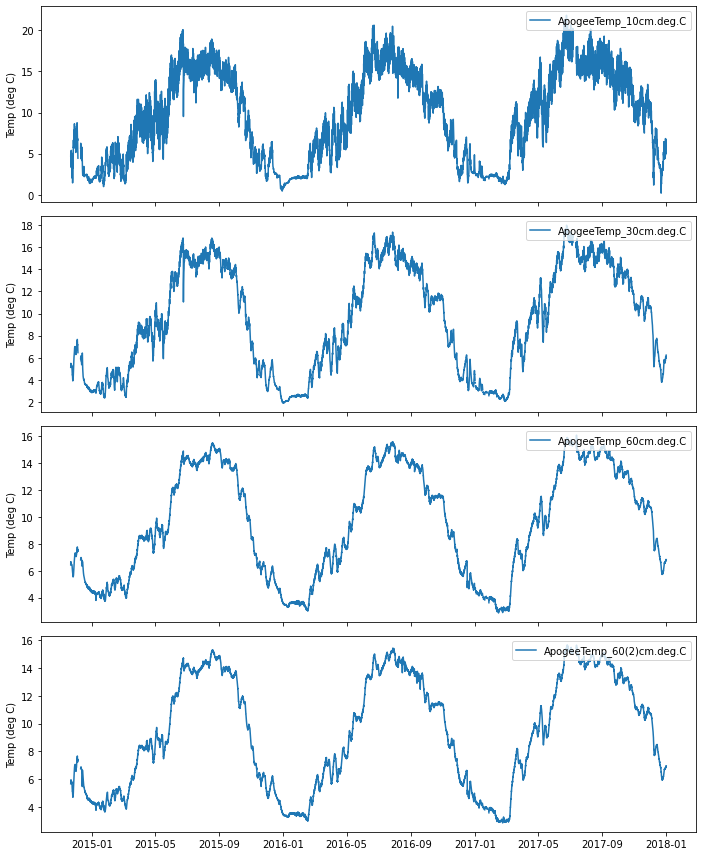

In [6]:
# Plot apogee thermistor temperature
apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

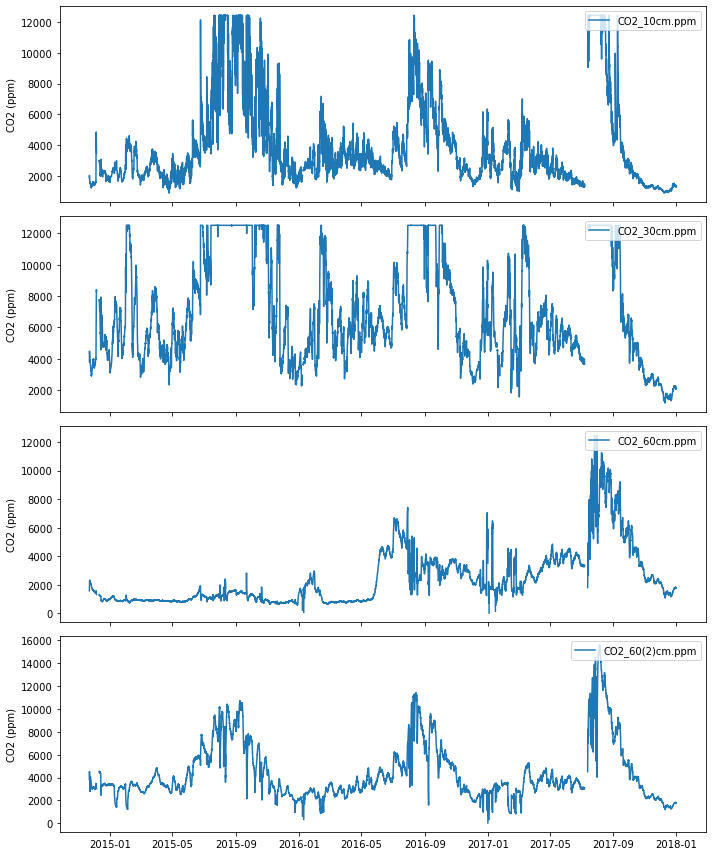

In [7]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

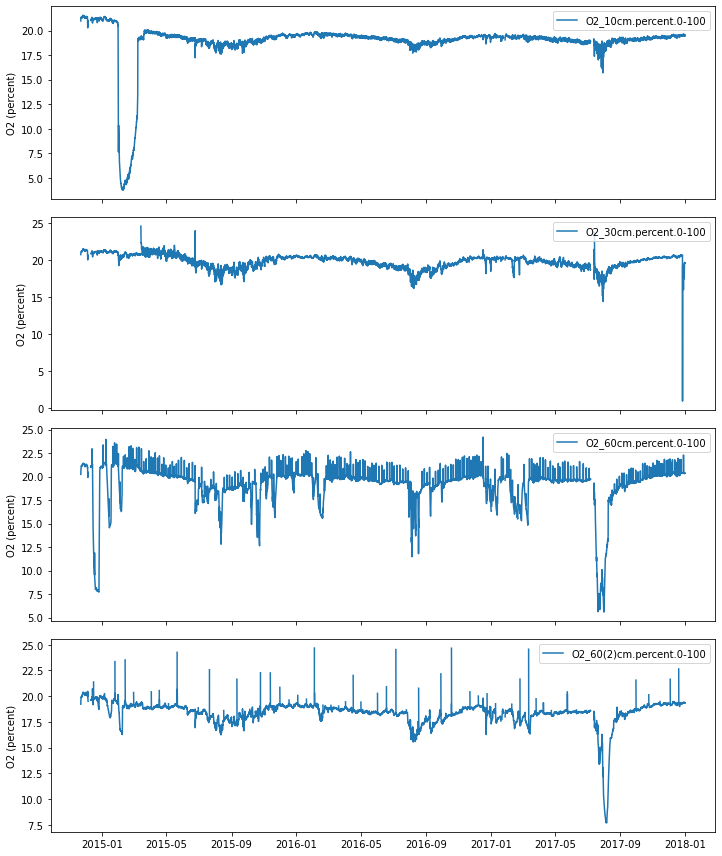

In [8]:
# Plot O2 data
# O2 mask and rolling mean produce curves with less noise. But are we sure that O2 can't be higher than 25? Also, I'm not sure what the best window size is.
df['O2_10cm.percent.0-100'].mask(df['O2_10cm.percent.0-100']>=25, inplace=True)
df['O2_30cm.percent.0-100'].mask(df['O2_30cm.percent.0-100']>=25, inplace=True)
df['O2_60cm.percent.0-100'].mask(df['O2_60cm.percent.0-100']>=25, inplace=True)
df['O2_60(2)cm.percent.0-100'].mask(df['O2_60(2)cm.percent.0-100']>=25, inplace=True)
#df['O2_60cm.percent.0-100.rolling_mean']=df['O2_60cm.percent.0-100'].rolling(4).mean()
#df['O2_60(2)cm.percent.0-100.rolling_mean']=df['O2_60(2)cm.percent.0-100'].rolling(4).mean()

o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

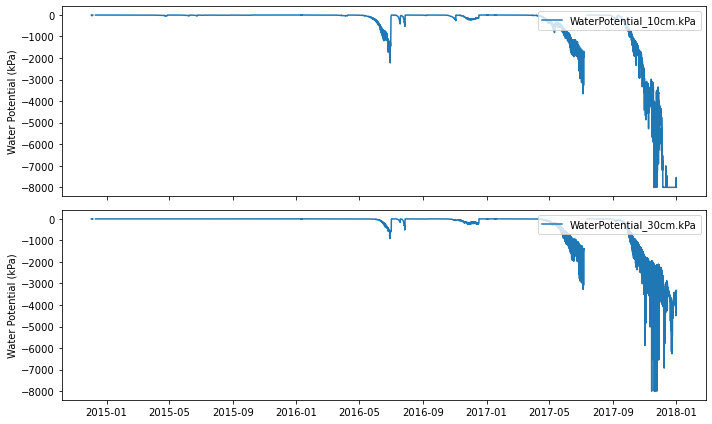

In [9]:
#Plot water potential
water_cols = [col for col in df.columns if 'Water' in col]
plot_cols(water_cols, ylabel='Water Potential (kPa)');

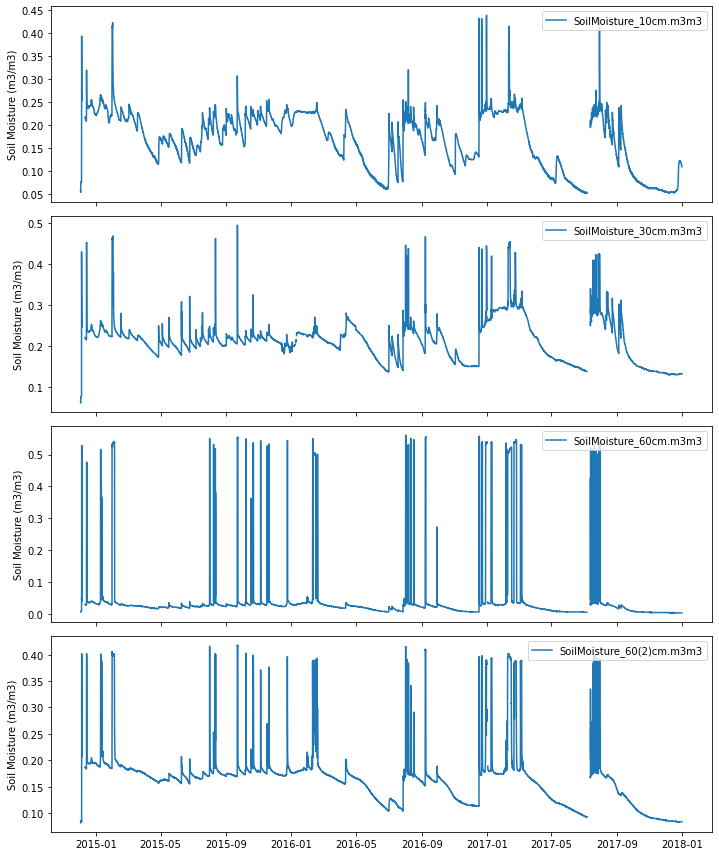

In [10]:
# Plot soil moisture data
sm_cols = [col for col in df.columns if 'SoilMoisture' in col]
plot_cols(sm_cols, ylabel='Soil Moisture (m3/m3)');

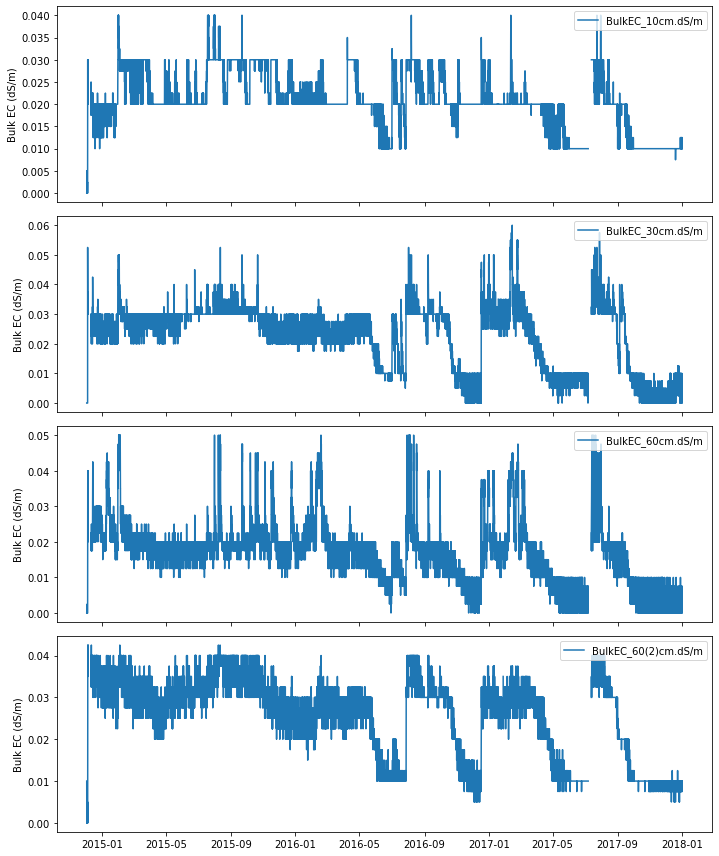

In [11]:
# Plot bulk EC
ec_cols = [col for col in df.columns if 'BulkEC' in col]
plot_cols(ec_cols, ylabel='Bulk EC (dS/m)');

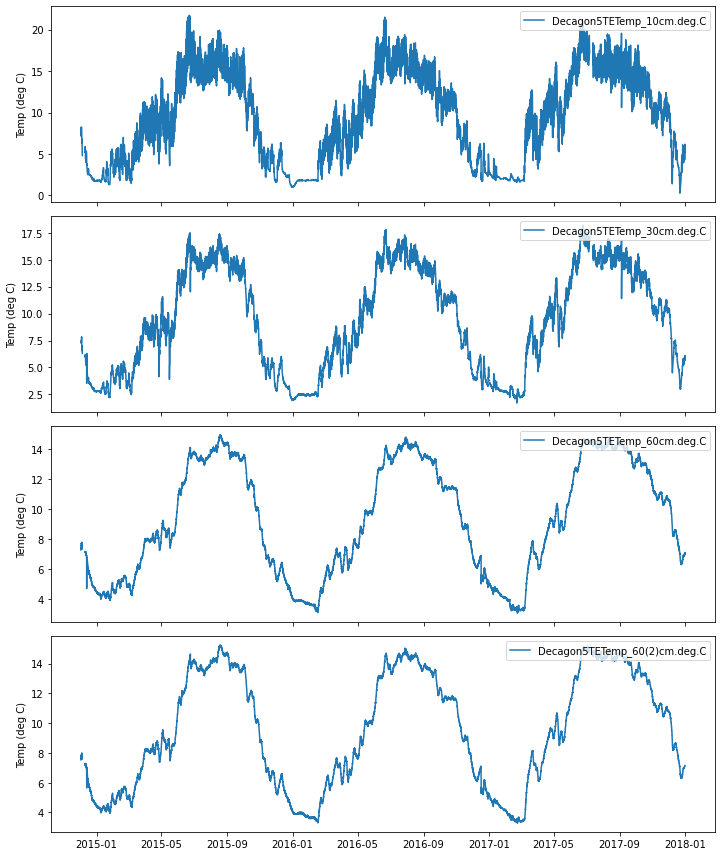

In [12]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'Decagon5TETemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [13]:
df=df.drop(columns='Decagon5TETemp_10cm.deg.C')
df=df.drop(columns='Decagon5TETemp_30cm.deg.C')
df=df.drop(columns='Decagon5TETemp_60cm.deg.C')
df=df.drop(columns='Decagon5TETemp_60(2)cm.deg.C')

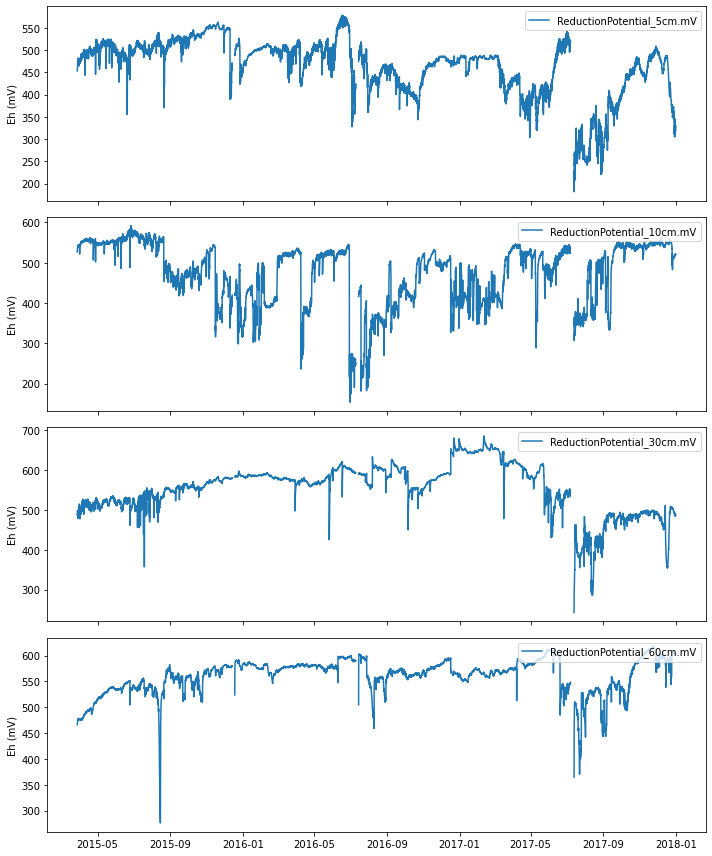

In [14]:
# Plot redox potential
eh_cols = [col for col in df.columns if 'ReductionPotential' in col]
plot_cols(eh_cols, ylabel='Eh (mV)');

In [15]:
output=df.copy()
outfile = '../../processed_data/Catalina-Jemez/BGZOB_Pit1_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.MST')

In [16]:
output

,ApogeeTemp_10cm.deg.C,ApogeeTemp_30cm.deg.C,ApogeeTemp_60cm.deg.C,ApogeeTemp_60(2)cm.deg.C,O2_10cm.percent.0-100,O2_30cm.percent.0-100,O2_60cm.percent.0-100,O2_60(2)cm.percent.0-100,CO2_10cm.ppm,CO2_30cm.ppm,...,SoilMoisture_60(2)cm.m3m3,BulkEC_10cm.dS/m,BulkEC_30cm.dS/m,BulkEC_60cm.dS/m,BulkEC_60(2)cm.dS/m,ReductionPotential_5cm.mV,ReductionPotential_10cm.mV,ReductionPotential_30cm.mV,ReductionPotential_60cm.mV,PRISM_precip.mm
2014-11-21 12:00:00,4.691333,5.132667,6.428333,5.66900,20.99300,20.748667,20.233667,19.219667,1870.97100,3808.55200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-21 13:00:00,4.943750,5.359500,6.675250,5.86650,21.20625,20.915250,20.456750,19.454750,2031.52775,4227.88325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-21 14:00:00,5.082000,5.386500,6.658500,5.85525,21.19550,20.895500,20.514750,19.502500,2009.46875,4406.97625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-21 15:00:00,5.268000,5.422500,6.650250,5.86300,21.18425,20.900500,20.575500,19.552250,1963.30525,4489.11725,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-21 16:00:00,5.121000,5.441500,6.622750,5.86050,21.20450,20.903000,20.631000,19.596250,1917.78125,4493.27125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,6.174750,6.192250,6.793250,6.91675,19.51850,19.631750,20.341500,19.339000,1303.72875,2117.93800,...,0.084,0.0100,0.0075,0.0025,0.01,323.450,519.500,487.500,603.575,NaN
2017-12-31 20:00:00,6.035750,6.215500,6.811750,6.92500,19.52925,19.628250,20.349500,19.340000,1295.31275,2118.23450,...,0.084,0.0100,0.0075,0.0050,0.01,325.825,519.925,487.250,603.575,NaN
2017-12-31 21:00:00,5.955500,6.232250,6.813250,6.92650,19.55050,19.630000,20.357500,19.356500,1284.22825,2111.23275,...,0.084,0.0100,0.0075,0.0025,0.01,326.550,520.775,486.675,603.475,NaN
2017-12-31 22:00:00,5.858500,6.235000,6.816750,6.93825,19.55550,19.630000,20.356000,19.357250,1285.30025,2110.38875,...,0.084,0.0125,0.0025,0.0025,0.01,327.775,520.925,486.825,603.550,NaN
